### Deep Neural Network for SOC Prediction with using Panasonic 18650PF Li-ion Battery

Panasonic 18650PF Li-ion Battery DataSet - https://data.mendeley.com/datasets/wykht8y7tg/1

In [37]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
PROCESSED_DATA_DIR = '../../datasets/Panasonic_dataset/Panasonic_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Voltage Average', 'Current Average', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 1024
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [40]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [41]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [42]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [43]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [44]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,3.86277,-2.23754,0.754623,-0.02364,3.895890,-1.700817,0.000029,-0.023551,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.643102
1,2017-05-30 20:17:33,50.097998,3.84797,-2.27755,0.754623,-0.02371,3.895549,-1.699886,0.000027,-0.023613,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.763944
2,2017-05-30 20:17:33,50.198993,3.84025,-2.29470,0.754623,-0.02377,3.895338,-1.698867,0.000028,-0.023677,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.812222
3,2017-05-30 20:17:33,50.296991,3.83575,-2.30205,0.754623,-0.02384,3.895206,-1.697771,0.000027,-0.023740,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.830088
4,2017-05-30 20:17:33,50.398992,3.83317,-2.30613,0.754623,-0.02390,3.895125,-1.696615,0.000028,-0.023805,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.839788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953837,2017-06-14 08:01:15,586318.964002,3.80679,-0.07268,-9.940246,-0.89027,3.744033,-0.525554,0.000026,0.871713,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4953838,2017-06-14 08:01:15,586319.064997,3.80679,-0.07268,-9.940246,-0.89027,3.743971,-0.525556,0.000028,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4953839,2017-06-14 08:01:15,586319.124995,3.80679,0.00000,-9.940246,-0.89028,3.743910,-0.525411,0.000017,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000
4953840,2017-06-14 08:01:15,586319.135999,3.80679,0.00000,-10.158136,-0.89028,3.743848,-0.525267,0.000003,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000


In [45]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,0.946053,-0.686221,-0.468729,-0.02364,1.141736,-0.783969,0.000029,1.252216,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.861626
1,2017-05-30 20:17:33,50.097998,0.893321,-0.708138,-0.468729,-0.02371,1.140427,-0.782946,0.000027,1.252146,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.881194
2,2017-05-30 20:17:33,50.198993,0.865814,-0.717532,-0.468729,-0.02377,1.139616,-0.781827,0.000028,1.252074,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.889011
3,2017-05-30 20:17:33,50.296991,0.849781,-0.721558,-0.468729,-0.02384,1.139107,-0.780622,0.000027,1.252004,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.891905
4,2017-05-30 20:17:33,50.398992,0.840588,-0.723793,-0.468729,-0.02390,1.138796,-0.779352,0.000028,1.251930,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.893475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953837,2017-06-14 08:01:15,586318.964002,0.746596,0.499659,-1.233183,-0.89027,0.558446,0.507342,0.000026,2.255737,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493145
4953838,2017-06-14 08:01:15,586319.064997,0.746596,0.499659,-1.233183,-0.89027,0.558208,0.507340,0.000028,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493145
4953839,2017-06-14 08:01:15,586319.124995,0.746596,0.539472,-1.233183,-0.89028,0.557971,0.507500,0.000017,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.537948
4953840,2017-06-14 08:01:15,586319.135999,0.746596,0.539472,-1.248758,-0.89028,0.557734,0.507658,0.000003,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.537948


In [46]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [47]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [48]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [49]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [50]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'03-27-17_09.06 10degC_LA92_Pan18650PF_processed.csv', '06-25-17_03.01 n20degC_Cycle_4_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_UDDS_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_NN_Pan18650PF_processed.csv', '06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv', '03-20-17_05.56 25degC_HWFTa_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv', '03-18-17_02.17 25degC_Cycle_1_Pan18650PF_processed.csv', '03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv', '03-20-17_19.27 25degC_HWFTb_Pan18650PF_processed.csv', '06-10-17_18.35 n10degC_Cycle_2_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_HWFET_Pan18650PF_processed.csv', '03-21-17_00.29 25degC_UDDS_Pan

In [52]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([4060415, 7])
Test features shape: torch.Size([323914, 7])
Train labels shape: torch.Size([4060415])
Test labels shape: torch.Size([323914])


## Hyperparameter tuning

In [66]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256, 512, 1024])
    num_layers = trial.suggest_int('num_layers', 1, 6)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [67]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-08-01 23:33:48,660] A new study created in memory with name: no-name-44d686a3-d644-48cd-872b-efe42af047d7
Epoch: 0/10: 100%|██████████| 3966/3966 [00:29<00:00, 134.05it/s]


Epoch 1/10, Train Loss: 0.019047013843696014, Validation Loss: 0.03890038164863621
Time taken for epoch: 29.58961320 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:30<00:00, 128.03it/s]


Epoch 2/10, Train Loss: 0.018780419475948922, Validation Loss: 0.05750852100039914
Time taken for epoch: 30.97821307 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:31<00:00, 124.14it/s]


Epoch 3/10, Train Loss: 0.019021762977154626, Validation Loss: 0.03788731397914262
Time taken for epoch: 31.95012307 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:32<00:00, 120.86it/s]


Epoch 4/10, Train Loss: 0.019238491235249237, Validation Loss: 0.07764104288841281
Time taken for epoch: 32.81567574 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:36<00:00, 109.37it/s]


Epoch 5/10, Train Loss: 0.019227925655152602, Validation Loss: 0.11520918170945854
Time taken for epoch: 36.26281309 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:47<00:00, 83.50it/s] 


Epoch 6/10, Train Loss: 0.019363852881648463, Validation Loss: 0.04060019778856387
Time taken for epoch: 47.50162220 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.17it/s] 


Epoch 7/10, Train Loss: 0.019369339000243943, Validation Loss: 0.028830956670065216
Time taken for epoch: 43.50397897 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.44it/s] 


Epoch 8/10, Train Loss: 0.01931397340589673, Validation Loss: 0.052604095803759375
Time taken for epoch: 41.55673122 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.79it/s] 


Epoch 9/10, Train Loss: 0.019371720494451662, Validation Loss: 0.06340584365590031
Time taken for epoch: 42.28889418 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:39<00:00, 99.96it/s] 
[I 2025-08-01 23:40:42,639] Trial 0 finished with value: 0.09582860869548972 and parameters: {'learning_rate': 0.0990031826586279, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.17949228733604275}. Best is trial 0 with value: 0.09582860869548972.


Epoch 10/10, Train Loss: 0.01944382656558191, Validation Loss: 0.09582860869548972
Time taken for epoch: 39.67938590 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [03:43<00:00, 17.74it/s]


Epoch 1/10, Train Loss: 0.013970380405690173, Validation Loss: 0.12556257337637755
Time taken for epoch: 223.62170815 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [03:46<00:00, 17.51it/s]


Epoch 2/10, Train Loss: 0.009834572344086594, Validation Loss: 0.13605760075118742
Time taken for epoch: 226.46065211 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [05:02<00:00, 13.12it/s]


Epoch 3/10, Train Loss: 0.009972768291160351, Validation Loss: 0.16116134404821728
Time taken for epoch: 302.25706387 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [04:40<00:00, 14.16it/s]


Epoch 4/10, Train Loss: 0.009981092461490504, Validation Loss: 0.15382805048885895
Time taken for epoch: 280.18238711 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [03:59<00:00, 16.54it/s]


Epoch 5/10, Train Loss: 0.01001280384791984, Validation Loss: 0.1575534492741316
Time taken for epoch: 239.84997201 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [03:42<00:00, 17.85it/s]


Epoch 6/10, Train Loss: 0.010043112484318361, Validation Loss: 0.13109206878303564
Time taken for epoch: 222.24211407 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [03:49<00:00, 17.28it/s]


Epoch 7/10, Train Loss: 0.01009920322976394, Validation Loss: 0.14669361216261054
Time taken for epoch: 229.56960607 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [04:06<00:00, 16.09it/s]


Epoch 8/10, Train Loss: 0.010105509955090327, Validation Loss: 0.17465044902448829
Time taken for epoch: 246.51126289 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [04:23<00:00, 15.07it/s]


Epoch 9/10, Train Loss: 0.010081187470154334, Validation Loss: 0.14444693766418434
Time taken for epoch: 263.25713897 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [03:54<00:00, 16.90it/s]
[I 2025-08-02 00:23:53,048] Trial 1 finished with value: 0.12317942352504815 and parameters: {'learning_rate': 0.0014223153787409014, 'hidden_size': 1024, 'num_layers': 5, 'dropout_rate': 0.57795145098455}. Best is trial 0 with value: 0.09582860869548972.


Epoch 10/10, Train Loss: 0.010131866775877657, Validation Loss: 0.12317942352504815
Time taken for epoch: 234.68656373 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:39<00:00, 99.39it/s] 


Epoch 1/10, Train Loss: 0.021349074676411204, Validation Loss: 0.10230730452729361
Time taken for epoch: 39.90520096 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.75it/s] 


Epoch 2/10, Train Loss: 0.02124999001748067, Validation Loss: 0.08391711184852886
Time taken for epoch: 42.30465198 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.49it/s] 


Epoch 3/10, Train Loss: 0.021213160400841043, Validation Loss: 0.0952493446869287
Time taken for epoch: 45.33238316 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.43it/s] 


Epoch 4/10, Train Loss: 0.021348916401356773, Validation Loss: 0.08147688446094453
Time taken for epoch: 43.85887098 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.48it/s] 


Epoch 5/10, Train Loss: 0.021486690276843908, Validation Loss: 0.09963043060121549
Time taken for epoch: 42.42710280 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.29it/s] 


Epoch 6/10, Train Loss: 0.021803594437633057, Validation Loss: 0.11306216633244895
Time taken for epoch: 43.92763186 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.62it/s] 


Epoch 7/10, Train Loss: 0.022130118758594726, Validation Loss: 0.09414269091801321
Time taken for epoch: 42.82052994 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.01it/s] 


Epoch 8/10, Train Loss: 0.02183833603093901, Validation Loss: 0.17395799376737459
Time taken for epoch: 42.64242268 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.86it/s] 


Epoch 9/10, Train Loss: 0.02173141560146695, Validation Loss: 0.06811873511945268
Time taken for epoch: 42.25606298 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.11it/s] 
[I 2025-08-02 00:31:43,370] Trial 2 finished with value: 0.08347781606345987 and parameters: {'learning_rate': 0.017437499082634346, 'hidden_size': 16, 'num_layers': 3, 'dropout_rate': 0.2438774007427657}. Best is trial 2 with value: 0.08347781606345987.


Epoch 10/10, Train Loss: 0.021702461758561796, Validation Loss: 0.08347781606345987
Time taken for epoch: 41.70251894 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [03:51<00:00, 17.11it/s]


Epoch 1/10, Train Loss: 0.005790235655287405, Validation Loss: 0.2481850695420603
Time taken for epoch: 231.79943681 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [03:38<00:00, 18.18it/s]


Epoch 2/10, Train Loss: 0.0026262959378381204, Validation Loss: 0.27137147141674955
Time taken for epoch: 218.14642572 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [03:46<00:00, 17.51it/s]


Epoch 3/10, Train Loss: 0.0027602126666772557, Validation Loss: 0.34254304052378914
Time taken for epoch: 226.48335123 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [03:31<00:00, 18.75it/s]


Epoch 4/10, Train Loss: 0.0027869280508239867, Validation Loss: 0.2524974824187385
Time taken for epoch: 211.55854988 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [03:40<00:00, 17.96it/s]


Epoch 5/10, Train Loss: 0.0027830333843924934, Validation Loss: 0.26828019231069183
Time taken for epoch: 220.80323005 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [03:37<00:00, 18.20it/s]


Epoch 6/10, Train Loss: 0.0027906712269893295, Validation Loss: 0.36006181772362567
Time taken for epoch: 217.85543394 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [03:51<00:00, 17.15it/s]


Epoch 7/10, Train Loss: 0.002789609670600057, Validation Loss: 0.28276832916482386
Time taken for epoch: 231.23236990 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [03:32<00:00, 18.63it/s]


Epoch 8/10, Train Loss: 0.0027817448185366053, Validation Loss: 0.23284917245620435
Time taken for epoch: 212.88614106 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [03:37<00:00, 18.20it/s]


Epoch 9/10, Train Loss: 0.0027838658995947983, Validation Loss: 0.25643373498769995
Time taken for epoch: 217.93665314 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [03:20<00:00, 19.82it/s]
[I 2025-08-02 01:10:06,057] Trial 3 finished with value: 0.24741355230319542 and parameters: {'learning_rate': 0.0005210017644935742, 'hidden_size': 1024, 'num_layers': 3, 'dropout_rate': 0.3371643997084714}. Best is trial 2 with value: 0.08347781606345987.


Epoch 10/10, Train Loss: 0.0027874312283136834, Validation Loss: 0.24741355230319542
Time taken for epoch: 200.10050106 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [01:47<00:00, 36.91it/s]


Epoch 1/10, Train Loss: 0.016748770960830658, Validation Loss: 0.08939965408342497
Time taken for epoch: 107.46366429 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [01:38<00:00, 40.40it/s]


Epoch 2/10, Train Loss: 0.01755149464277467, Validation Loss: 0.07776608004080617
Time taken for epoch: 98.17707324 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:39<00:00, 39.74it/s]


Epoch 3/10, Train Loss: 0.017755160960864297, Validation Loss: 0.09374101275968823
Time taken for epoch: 99.80055189 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:37<00:00, 40.76it/s]


Epoch 4/10, Train Loss: 0.017864982919477253, Validation Loss: 0.08986774282376332
Time taken for epoch: 97.30194712 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:38<00:00, 40.22it/s]


Epoch 5/10, Train Loss: 0.018030739198680694, Validation Loss: 0.10213135115701862
Time taken for epoch: 98.61937594 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:37<00:00, 40.56it/s]


Epoch 6/10, Train Loss: 0.017986465210261305, Validation Loss: 0.08361104994491889
Time taken for epoch: 97.78710485 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [01:37<00:00, 40.82it/s]


Epoch 7/10, Train Loss: 0.0180900668996831, Validation Loss: 0.08596621863765531
Time taken for epoch: 97.15155983 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [01:38<00:00, 40.19it/s]


Epoch 8/10, Train Loss: 0.018078727604923708, Validation Loss: 0.08678905243316058
Time taken for epoch: 98.67131686 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [01:58<00:00, 33.40it/s]


Epoch 9/10, Train Loss: 0.018085876820478408, Validation Loss: 0.09826988271411381
Time taken for epoch: 118.73707891 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [02:08<00:00, 30.75it/s]
[I 2025-08-02 01:28:33,215] Trial 4 finished with value: 0.08791131330665912 and parameters: {'learning_rate': 0.0036544988607593734, 'hidden_size': 512, 'num_layers': 4, 'dropout_rate': 0.6556073952572952}. Best is trial 2 with value: 0.08347781606345987.


Epoch 10/10, Train Loss: 0.018245639520416912, Validation Loss: 0.08791131330665912
Time taken for epoch: 128.95721197 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.09it/s]


Epoch 1/10, Train Loss: 0.006399133069804938, Validation Loss: 0.4356460566846939
Time taken for epoch: 62.86267591 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.15it/s]


Epoch 2/10, Train Loss: 0.0017523788928337943, Validation Loss: 0.3702057723233402
Time taken for epoch: 62.80988908 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.97it/s]


Epoch 3/10, Train Loss: 0.0018997476824835896, Validation Loss: 0.3540506343019055
Time taken for epoch: 62.00219417 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.63it/s]


Epoch 4/10, Train Loss: 0.001926851048458563, Validation Loss: 0.3550434944579233
Time taken for epoch: 62.33210874 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.67it/s]


Epoch 5/10, Train Loss: 0.001937115593268327, Validation Loss: 0.3334325929276986
Time taken for epoch: 62.28873086 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:01<00:00, 64.49it/s]


Epoch 6/10, Train Loss: 0.001939055904785037, Validation Loss: 0.37329879208313127
Time taken for epoch: 61.49541712 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [01:03<00:00, 62.88it/s]


Epoch 7/10, Train Loss: 0.0019427770721729407, Validation Loss: 0.36963196092328204
Time taken for epoch: 63.07315302 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.86it/s]


Epoch 8/10, Train Loss: 0.0019440738653279917, Validation Loss: 0.3743667913123845
Time taken for epoch: 62.10705209 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [01:01<00:00, 64.08it/s]


Epoch 9/10, Train Loss: 0.0019458733843716986, Validation Loss: 0.3471388978357681
Time taken for epoch: 61.89382291 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [01:02<00:00, 63.79it/s]
[I 2025-08-02 01:39:44,959] Trial 5 finished with value: 0.35723647068088454 and parameters: {'learning_rate': 0.00017032307607541767, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.11886471300895284}. Best is trial 2 with value: 0.08347781606345987.


Epoch 10/10, Train Loss: 0.0019467682256250616, Validation Loss: 0.35723647068088454
Time taken for epoch: 62.17705512 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [02:00<00:00, 32.78it/s]


Epoch 1/10, Train Loss: 0.01749807014799312, Validation Loss: 0.06582431105108043
Time taken for epoch: 120.97416091 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [02:03<00:00, 32.24it/s]


Epoch 2/10, Train Loss: 0.018578080281491268, Validation Loss: 0.039942524624442206
Time taken for epoch: 123.00491428 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [02:00<00:00, 32.94it/s]


Epoch 3/10, Train Loss: 0.01940132199189674, Validation Loss: 0.06785437381642731
Time taken for epoch: 120.42074013 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [02:01<00:00, 32.76it/s]


Epoch 4/10, Train Loss: 0.019556547262185957, Validation Loss: 0.2005529009994646
Time taken for epoch: 121.06864095 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [02:01<00:00, 32.76it/s]


Epoch 5/10, Train Loss: 0.01978102877813115, Validation Loss: 0.0668325225020156
Time taken for epoch: 121.05305696 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [02:01<00:00, 32.58it/s]


Epoch 6/10, Train Loss: 0.019581920172609634, Validation Loss: 0.06863396497512499
Time taken for epoch: 121.72716904 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [02:00<00:00, 32.81it/s]


Epoch 7/10, Train Loss: 0.01984529780548966, Validation Loss: 0.048039405181494216
Time taken for epoch: 120.87301302 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [02:01<00:00, 32.64it/s]


Epoch 8/10, Train Loss: 0.019830784325516562, Validation Loss: 0.0428794730533504
Time taken for epoch: 121.50056291 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [02:02<00:00, 32.48it/s]


Epoch 9/10, Train Loss: 0.01995899498042807, Validation Loss: 0.05399851369033225
Time taken for epoch: 122.12306786 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [02:01<00:00, 32.66it/s]
[I 2025-08-02 02:01:12,610] Trial 6 finished with value: 0.05375556787659965 and parameters: {'learning_rate': 0.02984846768845818, 'hidden_size': 512, 'num_layers': 3, 'dropout_rate': 0.5413045837731051}. Best is trial 6 with value: 0.05375556787659965.


Epoch 10/10, Train Loss: 0.019972524442486896, Validation Loss: 0.05375556787659965
Time taken for epoch: 121.43632007 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.46it/s]


Epoch 1/10, Train Loss: 0.06573446312533204, Validation Loss: 0.03987227434644895
Time taken for epoch: 60.58920407 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [01:01<00:00, 64.82it/s]


Epoch 2/10, Train Loss: 0.020841742893215973, Validation Loss: 0.09106627926399691
Time taken for epoch: 61.18395782 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.68it/s]


Epoch 3/10, Train Loss: 0.015282905453687372, Validation Loss: 0.13853594526167798
Time taken for epoch: 60.39025688 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.42it/s]


Epoch 4/10, Train Loss: 0.013598209790851634, Validation Loss: 0.17395090401364124
Time taken for epoch: 60.62394977 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.77it/s]


Epoch 5/10, Train Loss: 0.013430481699102315, Validation Loss: 0.17685125248490408
Time taken for epoch: 60.30755615 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:00<00:00, 66.04it/s]


Epoch 6/10, Train Loss: 0.013456115838463371, Validation Loss: 0.15862058950160415
Time taken for epoch: 60.05251503 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [01:01<00:00, 64.67it/s]


Epoch 7/10, Train Loss: 0.013600841663830429, Validation Loss: 0.16291004385182195
Time taken for epoch: 61.32811213 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.99it/s]


Epoch 8/10, Train Loss: 0.013710834730775352, Validation Loss: 0.1600752422100952
Time taken for epoch: 60.09851909 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.88it/s]


Epoch 9/10, Train Loss: 0.013806356983404914, Validation Loss: 0.1811394489048293
Time taken for epoch: 60.20680618 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.63it/s]
[I 2025-08-02 02:12:04,416] Trial 7 finished with value: 0.19935831613526472 and parameters: {'learning_rate': 3.152974730730359e-05, 'hidden_size': 128, 'num_layers': 5, 'dropout_rate': 0.32529044239636706}. Best is trial 6 with value: 0.05375556787659965.


Epoch 10/10, Train Loss: 0.013794092134588064, Validation Loss: 0.19935831613526472
Time taken for epoch: 60.43250895 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.65it/s] 


Epoch 1/10, Train Loss: 0.011349708732922969, Validation Loss: 0.2351118352068708
Time taken for epoch: 41.46596217 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.68it/s] 


Epoch 2/10, Train Loss: 0.005323530109040345, Validation Loss: 0.21249314213952125
Time taken for epoch: 41.89086390 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.46it/s] 


Epoch 3/10, Train Loss: 0.005340044786712127, Validation Loss: 0.22647670487833427
Time taken for epoch: 42.43724585 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.77it/s] 


Epoch 4/10, Train Loss: 0.005351406441080002, Validation Loss: 0.226980569111156
Time taken for epoch: 41.84904909 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.30it/s] 


Epoch 5/10, Train Loss: 0.005352256641959451, Validation Loss: 0.21544608330793694
Time taken for epoch: 41.61680102 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:39<00:00, 99.17it/s] 


Epoch 6/10, Train Loss: 0.005341574002998499, Validation Loss: 0.21498573314046923
Time taken for epoch: 39.99359202 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:37<00:00, 106.20it/s]


Epoch 7/10, Train Loss: 0.005328059245081289, Validation Loss: 0.19422170646667059
Time taken for epoch: 37.34755921 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:35<00:00, 110.81it/s]


Epoch 8/10, Train Loss: 0.005338259662895553, Validation Loss: 0.23160014001254994
Time taken for epoch: 35.79288077 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:36<00:00, 109.21it/s]


Epoch 9/10, Train Loss: 0.005339493825576121, Validation Loss: 0.23383037208622157
Time taken for epoch: 36.31844568 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:37<00:00, 106.80it/s]
[I 2025-08-02 02:19:20,744] Trial 8 finished with value: 0.22414698062451244 and parameters: {'learning_rate': 0.0007816809047931753, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.5876698549879525}. Best is trial 6 with value: 0.05375556787659965.


Epoch 10/10, Train Loss: 0.005336001994082656, Validation Loss: 0.22414698062451244
Time taken for epoch: 37.13865089 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.90it/s] 


Epoch 1/10, Train Loss: 0.09986511156699361, Validation Loss: 0.08194403733166256
Time taken for epoch: 44.11953998 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.82it/s] 


Epoch 2/10, Train Loss: 0.08237057781683875, Validation Loss: 0.08381199867797304
Time taken for epoch: 44.15714574 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.96it/s] 


Epoch 3/10, Train Loss: 0.08245847901903315, Validation Loss: 0.08314082063940441
Time taken for epoch: 44.08870602 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.23it/s] 


Epoch 4/10, Train Loss: 0.08245892616846437, Validation Loss: 0.08185979373212383
Time taken for epoch: 43.95501494 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.24it/s] 


Epoch 5/10, Train Loss: 0.08246436574230036, Validation Loss: 0.08266627649915359
Time taken for epoch: 43.95144606 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.35it/s] 


Epoch 6/10, Train Loss: 0.08245632194632602, Validation Loss: 0.08339454892363443
Time taken for epoch: 43.89894676 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.67it/s] 


Epoch 7/10, Train Loss: 0.08245825916115407, Validation Loss: 0.08184340423862853
Time taken for epoch: 43.74411130 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.70it/s] 


Epoch 8/10, Train Loss: 0.08245659314670829, Validation Loss: 0.08260841271735289
Time taken for epoch: 44.21861792 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.48it/s] 


Epoch 9/10, Train Loss: 0.08246600479112992, Validation Loss: 0.08276920685139998
Time taken for epoch: 44.32526803 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.97it/s] 
[I 2025-08-02 02:27:21,154] Trial 9 finished with value: 0.08184187902026231 and parameters: {'learning_rate': 0.017587030504269324, 'hidden_size': 16, 'num_layers': 5, 'dropout_rate': 0.6873564649093982}. Best is trial 6 with value: 0.05375556787659965.


Epoch 10/10, Train Loss: 0.08245923371813661, Validation Loss: 0.08184187902026231
Time taken for epoch: 44.08242202 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.98it/s] 


Epoch 1/10, Train Loss: 0.08072668107209349, Validation Loss: 0.03559528992497446
Time taken for epoch: 49.59129190 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.58it/s]


Epoch 2/10, Train Loss: 0.011427926553499689, Validation Loss: 0.12768567693434907
Time taken for epoch: 50.47471189 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.04it/s]


Epoch 3/10, Train Loss: 0.01507592358167574, Validation Loss: 0.052462406629992936
Time taken for epoch: 50.18205190 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.81it/s]


Epoch 4/10, Train Loss: 0.016467255960062214, Validation Loss: 0.10171050117956182
Time taken for epoch: 50.32379699 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 77.84it/s]


Epoch 5/10, Train Loss: 0.01460373924718254, Validation Loss: 0.04035663167674649
Time taken for epoch: 50.95029211 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.29it/s]


Epoch 6/10, Train Loss: 0.014954637402393379, Validation Loss: 0.0746126909822055
Time taken for epoch: 50.66056776 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.16it/s]


Epoch 7/10, Train Loss: 0.01453892953305933, Validation Loss: 0.09799872971380412
Time taken for epoch: 50.74337482 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.47it/s]


Epoch 8/10, Train Loss: 0.014277241257570244, Validation Loss: 0.09059307911788803
Time taken for epoch: 51.19431424 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.78it/s]


Epoch 9/10, Train Loss: 0.014363969329827236, Validation Loss: 0.032466766773585905
Time taken for epoch: 50.34452415 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.48it/s]
[I 2025-08-02 02:36:31,703] Trial 10 finished with value: 0.048124708005799294 and parameters: {'learning_rate': 0.09739931253618095, 'hidden_size': 512, 'num_layers': 1, 'dropout_rate': 0.4888646833205879}. Best is trial 10 with value: 0.048124708005799294.


Epoch 10/10, Train Loss: 0.014565607265391271, Validation Loss: 0.048124708005799294
Time taken for epoch: 51.19079399 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:51<00:00, 76.67it/s]


Epoch 1/10, Train Loss: 0.20013876419678325, Validation Loss: 0.11326066894873499
Time taken for epoch: 51.73201990 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.29it/s]


Epoch 2/10, Train Loss: 0.01155633478734475, Validation Loss: 0.08916208828039487
Time taken for epoch: 51.31739306 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.67it/s]


Epoch 3/10, Train Loss: 0.014523692091150125, Validation Loss: 0.0948247854087426
Time taken for epoch: 51.06326389 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.12it/s]


Epoch 4/10, Train Loss: 0.017214401658677013, Validation Loss: 0.08528045498461852
Time taken for epoch: 50.77232814 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.06it/s]


Epoch 5/10, Train Loss: 0.015015919732500058, Validation Loss: 0.05622809552409132
Time taken for epoch: 51.47021103 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.60it/s]


Epoch 6/10, Train Loss: 0.015272612276520398, Validation Loss: 0.06601030090294205
Time taken for epoch: 51.10753727 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.03it/s]


Epoch 7/10, Train Loss: 0.014509778305187453, Validation Loss: 0.0394902552982865
Time taken for epoch: 50.82888103 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.70it/s]


Epoch 8/10, Train Loss: 0.014467426830037594, Validation Loss: 0.07031589289214593
Time taken for epoch: 51.04224110 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.40it/s]


Epoch 9/10, Train Loss: 0.014180119662483158, Validation Loss: 0.08482613874310664
Time taken for epoch: 51.24016905 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:50<00:00, 77.91it/s]
[I 2025-08-02 02:45:47,923] Trial 11 finished with value: 0.0631427147774526 and parameters: {'learning_rate': 0.09925558805641672, 'hidden_size': 512, 'num_layers': 1, 'dropout_rate': 0.47823656089700867}. Best is trial 10 with value: 0.048124708005799294.


Epoch 10/10, Train Loss: 0.014445265235855567, Validation Loss: 0.0631427147774526
Time taken for epoch: 50.90724778 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.16it/s] 


Epoch 1/10, Train Loss: 0.012668929845461011, Validation Loss: 0.1448667230247052
Time taken for epoch: 45.50488782 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:46<00:00, 86.12it/s] 


Epoch 2/10, Train Loss: 0.012431404826457205, Validation Loss: 0.08759535671879756
Time taken for epoch: 46.05344987 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:46<00:00, 85.84it/s] 


Epoch 3/10, Train Loss: 0.012703849561136748, Validation Loss: 0.1005435957050465
Time taken for epoch: 46.20537186 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.84it/s] 


Epoch 4/10, Train Loss: 0.012792700201609237, Validation Loss: 0.0843236114638357
Time taken for epoch: 45.67358112 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:46<00:00, 85.13it/s] 


Epoch 5/10, Train Loss: 0.013055293609924048, Validation Loss: 0.09767483732851147
Time taken for epoch: 46.59032083 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:48<00:00, 82.31it/s]


Epoch 6/10, Train Loss: 0.01329836863024039, Validation Loss: 0.0706919183228614
Time taken for epoch: 48.18302727 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:48<00:00, 82.34it/s] 


Epoch 7/10, Train Loss: 0.0133752791587671, Validation Loss: 0.10800113429535456
Time taken for epoch: 48.17092323 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:48<00:00, 82.45it/s]


Epoch 8/10, Train Loss: 0.013529417689502676, Validation Loss: 0.17571041164262155
Time taken for epoch: 48.10618091 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:48<00:00, 82.21it/s]


Epoch 9/10, Train Loss: 0.01366133710808124, Validation Loss: 0.10415715358347115
Time taken for epoch: 48.24245811 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:47<00:00, 84.27it/s] 
[I 2025-08-02 02:54:22,317] Trial 12 finished with value: 0.09939940974695763 and parameters: {'learning_rate': 0.01638433803867564, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.4759343024796335}. Best is trial 10 with value: 0.048124708005799294.


Epoch 10/10, Train Loss: 0.013838752953451177, Validation Loss: 0.09939940974695763
Time taken for epoch: 47.06660414 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [02:18<00:00, 28.59it/s]


Epoch 1/10, Train Loss: 0.032964860644253496, Validation Loss: 0.07407935850738073
Time taken for epoch: 138.70467114 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [02:18<00:00, 28.57it/s]


Epoch 2/10, Train Loss: 0.03428602388971196, Validation Loss: 0.04017116073423764
Time taken for epoch: 138.82094121 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:52<00:00, 35.41it/s]


Epoch 3/10, Train Loss: 0.03482947264578658, Validation Loss: 0.04098209905987297
Time taken for epoch: 112.01135373 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:46<00:00, 37.25it/s]


Epoch 4/10, Train Loss: 0.03469525952600375, Validation Loss: 0.05323989851912264
Time taken for epoch: 106.46635294 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:46<00:00, 37.14it/s]


Epoch 5/10, Train Loss: 0.034278933822533816, Validation Loss: 0.06519587980147144
Time taken for epoch: 106.78062010 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.29it/s]


Epoch 6/10, Train Loss: 0.03449068895334014, Validation Loss: 0.04951551395389815
Time taken for epoch: 103.57968593 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.15it/s]


Epoch 7/10, Train Loss: 0.0342868446093945, Validation Loss: 0.07202418280811614
Time taken for epoch: 103.95862484 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [01:44<00:00, 38.11it/s]


Epoch 8/10, Train Loss: 0.03433160141976461, Validation Loss: 0.0648609447776064
Time taken for epoch: 104.07006192 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [01:44<00:00, 38.11it/s]


Epoch 9/10, Train Loss: 0.03404816701224866, Validation Loss: 0.05894083346967648
Time taken for epoch: 104.06489587 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [02:11<00:00, 30.20it/s]
[I 2025-08-02 03:14:38,590] Trial 13 finished with value: 0.05190919417401482 and parameters: {'learning_rate': 0.037886720104934594, 'hidden_size': 512, 'num_layers': 6, 'dropout_rate': 0.47861975781053223}. Best is trial 10 with value: 0.048124708005799294.


Epoch 10/10, Train Loss: 0.03425085554965521, Validation Loss: 0.05190919417401482
Time taken for epoch: 131.34110999 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [02:15<00:00, 29.20it/s]


Epoch 1/10, Train Loss: 0.0207291487651345, Validation Loss: 0.07831054302585527
Time taken for epoch: 135.84689784 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [02:00<00:00, 32.82it/s]


Epoch 2/10, Train Loss: 0.019151034717040865, Validation Loss: 0.08922185813252828
Time taken for epoch: 120.86133695 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.23it/s]


Epoch 3/10, Train Loss: 0.019384195578655117, Validation Loss: 0.0953596846102333
Time taken for epoch: 103.73736215 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:42<00:00, 38.54it/s]


Epoch 4/10, Train Loss: 0.019584596512601554, Validation Loss: 0.07714145132095368
Time taken for epoch: 102.90865397 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.42it/s]


Epoch 5/10, Train Loss: 0.019912538040697994, Validation Loss: 0.07198073882477933
Time taken for epoch: 103.23763108 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.45it/s]


Epoch 6/10, Train Loss: 0.020002103306867833, Validation Loss: 0.12185718471211962
Time taken for epoch: 103.15374279 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [02:10<00:00, 30.28it/s]


Epoch 7/10, Train Loss: 0.020207923984007586, Validation Loss: 0.09628933434358576
Time taken for epoch: 130.99871683 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [01:55<00:00, 34.40it/s]


Epoch 8/10, Train Loss: 0.0202481295604426, Validation Loss: 0.08614523808187456
Time taken for epoch: 115.29939508 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [01:43<00:00, 38.44it/s]


Epoch 9/10, Train Loss: 0.020290890908638035, Validation Loss: 0.10348379088557896
Time taken for epoch: 103.17711091 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [01:44<00:00, 38.06it/s]
[I 2025-08-02 03:34:26,848] Trial 14 finished with value: 0.0898780980598263 and parameters: {'learning_rate': 0.005563691532919736, 'hidden_size': 512, 'num_layers': 6, 'dropout_rate': 0.4334563804483565}. Best is trial 10 with value: 0.048124708005799294.


Epoch 10/10, Train Loss: 0.02053168563447438, Validation Loss: 0.0898780980598263
Time taken for epoch: 104.21329188 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [01:46<00:00, 37.13it/s]


Epoch 1/10, Train Loss: 0.023822748639061482, Validation Loss: 0.06511922701323802
Time taken for epoch: 106.80257320 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.59it/s]


Epoch 2/10, Train Loss: 0.0267474244212975, Validation Loss: 0.07762700732885898
Time taken for epoch: 129.67172194 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.54it/s]


Epoch 3/10, Train Loss: 0.02693887487564854, Validation Loss: 0.041509652238228896
Time taken for epoch: 129.87752509 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.64it/s]


Epoch 4/10, Train Loss: 0.02691640001940069, Validation Loss: 0.12456365278877608
Time taken for epoch: 129.46118188 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [02:10<00:00, 30.37it/s]


Epoch 5/10, Train Loss: 0.02648940432085963, Validation Loss: 0.08082610454572528
Time taken for epoch: 130.59354496 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.59it/s]


Epoch 6/10, Train Loss: 0.02665600496185995, Validation Loss: 0.04024303827114453
Time taken for epoch: 129.67015290 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.66it/s]


Epoch 7/10, Train Loss: 0.02680542739930098, Validation Loss: 0.05195853665018034
Time taken for epoch: 129.36471987 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.68it/s]


Epoch 8/10, Train Loss: 0.026642073237957583, Validation Loss: 0.04733743429591727
Time taken for epoch: 129.27484703 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.62it/s]


Epoch 9/10, Train Loss: 0.026729526030171175, Validation Loss: 0.042566511449117723
Time taken for epoch: 129.53727579 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [02:09<00:00, 30.55it/s]
[I 2025-08-02 03:56:57,137] Trial 15 finished with value: 0.041880748215547395 and parameters: {'learning_rate': 0.0499391420528181, 'hidden_size': 512, 'num_layers': 4, 'dropout_rate': 0.4169276562014068}. Best is trial 15 with value: 0.041880748215547395.


Epoch 10/10, Train Loss: 0.026546548598784574, Validation Loss: 0.041880748215547395
Time taken for epoch: 129.82704592 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.54it/s]


Epoch 1/10, Train Loss: 0.009531140324283453, Validation Loss: 0.16780735703081978
Time taken for epoch: 74.07241130 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.14it/s]


Epoch 2/10, Train Loss: 0.009251208258515662, Validation Loss: 0.15368380041910187
Time taken for epoch: 74.63515592 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.45it/s]


Epoch 3/10, Train Loss: 0.009383056411191828, Validation Loss: 0.10497523125115575
Time taken for epoch: 74.20825100 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.14it/s]


Epoch 4/10, Train Loss: 0.009439472444059606, Validation Loss: 0.1379666277238589
Time taken for epoch: 74.63937783 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [01:13<00:00, 54.22it/s]


Epoch 5/10, Train Loss: 0.009479818807889492, Validation Loss: 0.15300058165380268
Time taken for epoch: 73.14358020 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.09it/s]


Epoch 6/10, Train Loss: 0.009612880397796541, Validation Loss: 0.16168198259868827
Time taken for epoch: 74.70279813 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.03it/s]


Epoch 7/10, Train Loss: 0.009643499938601113, Validation Loss: 0.15622731449324945
Time taken for epoch: 74.78974009 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.22it/s]


Epoch 8/10, Train Loss: 0.00966685180952918, Validation Loss: 0.1769169709022399
Time taken for epoch: 74.52306080 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [01:13<00:00, 53.71it/s]


Epoch 9/10, Train Loss: 0.009757671588458838, Validation Loss: 0.2466073238762794
Time taken for epoch: 73.84096503 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [01:14<00:00, 53.56it/s]
[I 2025-08-02 04:10:11,575] Trial 16 finished with value: 0.13070677685179005 and parameters: {'learning_rate': 0.005064452434493781, 'hidden_size': 256, 'num_layers': 4, 'dropout_rate': 0.3643407653268647}. Best is trial 15 with value: 0.041880748215547395.


Epoch 10/10, Train Loss: 0.009815199679657029, Validation Loss: 0.13070677685179005
Time taken for epoch: 74.05556297 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.29it/s] 


Epoch 1/10, Train Loss: 0.3368303819220895, Validation Loss: 0.15089217084752565
Time taken for epoch: 45.43440223 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:46<00:00, 86.15it/s] 


Epoch 2/10, Train Loss: 0.08322685297373804, Validation Loss: 0.08073480560594151
Time taken for epoch: 46.03830504 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:46<00:00, 85.47it/s] 


Epoch 3/10, Train Loss: 0.04314068706675169, Validation Loss: 0.08743290426496166
Time taken for epoch: 46.40370798 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:46<00:00, 85.87it/s] 


Epoch 4/10, Train Loss: 0.02372920521559871, Validation Loss: 0.10137400084765973
Time taken for epoch: 46.18782997 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.42it/s] 


Epoch 5/10, Train Loss: 0.015027483172603872, Validation Loss: 0.12896850265039936
Time taken for epoch: 45.89714098 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.97it/s] 


Epoch 6/10, Train Loss: 0.011064939263576865, Validation Loss: 0.14603277742489776
Time taken for epoch: 45.60539794 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.74it/s] 


Epoch 7/10, Train Loss: 0.008892384973700772, Validation Loss: 0.16600891768101642
Time taken for epoch: 45.72704077 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.05it/s] 


Epoch 8/10, Train Loss: 0.007644341750759904, Validation Loss: 0.18238331872432373
Time taken for epoch: 45.56263304 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.83it/s] 


Epoch 9/10, Train Loss: 0.006816743383680968, Validation Loss: 0.1821382469926994
Time taken for epoch: 45.67762280 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.81it/s] 
[I 2025-08-02 04:18:32,730] Trial 17 finished with value: 0.19886921249749803 and parameters: {'learning_rate': 1.1734976200266832e-05, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.2978100023003167}. Best is trial 15 with value: 0.041880748215547395.


Epoch 10/10, Train Loss: 0.006356441320154479, Validation Loss: 0.19886921249749803
Time taken for epoch: 45.16984177 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.00it/s]


Epoch 1/10, Train Loss: 0.04355179427160618, Validation Loss: 0.0629347672123508
Time taken for epoch: 48.96507692 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.67it/s]


Epoch 2/10, Train Loss: 0.04234128677395637, Validation Loss: 0.0493029904039463
Time taken for epoch: 48.56372619 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.48it/s]


Epoch 3/10, Train Loss: 0.041717095155902, Validation Loss: 0.05924179420817725
Time taken for epoch: 49.28013325 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.34it/s]


Epoch 4/10, Train Loss: 0.04192736114605893, Validation Loss: 0.07283628473076964
Time taken for epoch: 48.76181889 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.52it/s]


Epoch 5/10, Train Loss: 0.04201732888776458, Validation Loss: 0.0647419397431636
Time taken for epoch: 49.25435185 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.84it/s]


Epoch 6/10, Train Loss: 0.042329707096057954, Validation Loss: 0.05802502773613618
Time taken for epoch: 49.67885017 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.75it/s]


Epoch 7/10, Train Loss: 0.042459966399741186, Validation Loss: 0.04193120626995073
Time taken for epoch: 48.51462817 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.37it/s]


Epoch 8/10, Train Loss: 0.04225374069074249, Validation Loss: 0.0658500317186659
Time taken for epoch: 48.74222016 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.39it/s]


Epoch 9/10, Train Loss: 0.04243403468027418, Validation Loss: 0.08066470653165389
Time taken for epoch: 49.33449697 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.09it/s]
[I 2025-08-02 04:27:26,996] Trial 18 finished with value: 0.05071934129989688 and parameters: {'learning_rate': 0.05256939194662394, 'hidden_size': 32, 'num_layers': 4, 'dropout_rate': 0.4080226386275185}. Best is trial 15 with value: 0.041880748215547395.


Epoch 10/10, Train Loss: 0.043005897385968564, Validation Loss: 0.05071934129989688
Time taken for epoch: 48.91153502 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:53<00:00, 73.82it/s]


Epoch 1/10, Train Loss: 0.05327921351854677, Validation Loss: 0.3986689931496118
Time taken for epoch: 53.72774601 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:52<00:00, 75.28it/s]


Epoch 2/10, Train Loss: 0.004963955119925218, Validation Loss: 0.5365143082055422
Time taken for epoch: 52.68739891 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:52<00:00, 75.59it/s]


Epoch 3/10, Train Loss: 0.0028621319850950875, Validation Loss: 0.39834155009360467
Time taken for epoch: 52.46674013 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:51<00:00, 76.96it/s]


Epoch 4/10, Train Loss: 0.0028943948510403036, Validation Loss: 0.2373786536860097
Time taken for epoch: 51.53270721 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.25it/s]


Epoch 5/10, Train Loss: 0.0029056025039643214, Validation Loss: 0.23802328571792605
Time taken for epoch: 51.34192991 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.19it/s]


Epoch 6/10, Train Loss: 0.002901863729390088, Validation Loss: 0.23596024720654815
Time taken for epoch: 50.72548509 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.69it/s]


Epoch 7/10, Train Loss: 0.0029063180901027514, Validation Loss: 0.24018100014943605
Time taken for epoch: 51.05064130 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:51<00:00, 76.95it/s]


Epoch 8/10, Train Loss: 0.002910050027404944, Validation Loss: 0.2402429399587475
Time taken for epoch: 51.53978395 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.51it/s]


Epoch 9/10, Train Loss: 0.002912304357863189, Validation Loss: 0.24913572318891605
Time taken for epoch: 51.17278099 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.51it/s] 
[I 2025-08-02 04:36:46,613] Trial 19 finished with value: 0.23386335272896716 and parameters: {'learning_rate': 9.566944257922653e-05, 'hidden_size': 512, 'num_layers': 1, 'dropout_rate': 0.5391888935443229}. Best is trial 15 with value: 0.041880748215547395.


Epoch 10/10, Train Loss: 0.0029126263282412547, Validation Loss: 0.23386335272896716
Time taken for epoch: 49.26468396 seconds
Best hyperparameters: {'learning_rate': 0.0499391420528181, 'hidden_size': 512, 'num_layers': 4, 'dropout_rate': 0.4169276562014068}


### Best hyperparameters: {'learning_rate': 0.09169063844501016, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.35129304483985335}

### Training and Validation

In [68]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4169276562014068, inplace=False)
)
Trainable parameters: 178561


Epoch: 0/50: 100%|██████████| 3966/3966 [01:37<00:00, 40.63it/s]


Epoch 1/50, Train Loss: 0.024095165083702397, Validation Loss: 0.048941883956977565
Time taken for epoch: 97.62498617 seconds


Epoch: 1/50: 100%|██████████| 3966/3966 [01:56<00:00, 34.11it/s]


Epoch 2/50, Train Loss: 0.027233251793177603, Validation Loss: 0.0640528166024958
Time taken for epoch: 116.26661420 seconds


Epoch: 2/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.81it/s]


Epoch 3/50, Train Loss: 0.02708052488328514, Validation Loss: 0.06774623365513688
Time taken for epoch: 128.72553706 seconds


Epoch: 3/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.58it/s]


Epoch 4/50, Train Loss: 0.026847414990330037, Validation Loss: 0.0403979923129762
Time taken for epoch: 129.68361092 seconds


Epoch: 4/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.69it/s]


Epoch 5/50, Train Loss: 0.02690520234578827, Validation Loss: 0.05186869865138896
Time taken for epoch: 129.21564007 seconds


Epoch: 5/50: 100%|██████████| 3966/3966 [02:10<00:00, 30.51it/s]


Epoch 6/50, Train Loss: 0.027361059304471427, Validation Loss: 0.044521602640026484
Time taken for epoch: 130.01340699 seconds


Epoch: 6/50: 100%|██████████| 3966/3966 [02:23<00:00, 27.68it/s]


Epoch 7/50, Train Loss: 0.02710655156947556, Validation Loss: 0.0702972822210823
Time taken for epoch: 143.27455163 seconds


Epoch: 7/50: 100%|██████████| 3966/3966 [02:23<00:00, 27.61it/s]


Epoch 8/50, Train Loss: 0.02657684983720367, Validation Loss: 0.09075394862141152
Time taken for epoch: 143.64830804 seconds


Epoch: 8/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.61it/s]


Epoch 9/50, Train Loss: 0.027030166038474048, Validation Loss: 0.07133106385025152
Time taken for epoch: 129.57271814 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.67it/s]


Epoch 10/50, Train Loss: 0.026689418943798938, Validation Loss: 0.07528800559225642
Time taken for epoch: 129.33420801 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.66it/s]


Epoch 11/50, Train Loss: 0.026455784744413527, Validation Loss: 0.04257546596296898
Time taken for epoch: 129.34515381 seconds
Early stopping triggered


Epoch: 11/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.74it/s]


Epoch 12/50, Train Loss: 0.026622514702582593, Validation Loss: 0.04936228585022454
Time taken for epoch: 129.01175213 seconds
Early stopping triggered


Epoch: 12/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.78it/s]


Epoch 13/50, Train Loss: 0.026221941737152834, Validation Loss: 0.0710755016000573
Time taken for epoch: 128.85881686 seconds
Early stopping triggered


Epoch: 13/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.73it/s]


Epoch 14/50, Train Loss: 0.02707110723152764, Validation Loss: 0.10685749179547904
Time taken for epoch: 129.06528687 seconds
Early stopping triggered


Epoch: 14/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.73it/s]


Epoch 15/50, Train Loss: 0.027195384312633367, Validation Loss: 0.04003495042867091
Time taken for epoch: 129.05236387 seconds


Epoch: 15/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.77it/s]


Epoch 16/50, Train Loss: 0.027234134420684897, Validation Loss: 0.04490555518138178
Time taken for epoch: 128.87693787 seconds


Epoch: 16/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.62it/s]


Epoch 17/50, Train Loss: 0.02703588950507384, Validation Loss: 0.09179929585789755
Time taken for epoch: 129.51822615 seconds


Epoch: 17/50: 100%|██████████| 3966/3966 [02:10<00:00, 30.28it/s]


Epoch 18/50, Train Loss: 0.02732443355354497, Validation Loss: 0.0816395161912165
Time taken for epoch: 130.98546576 seconds


Epoch: 18/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.78it/s]


Epoch 19/50, Train Loss: 0.027442640189102096, Validation Loss: 0.0419877331308547
Time taken for epoch: 128.85376692 seconds


Epoch: 19/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.77it/s]


Epoch 20/50, Train Loss: 0.027179384558540038, Validation Loss: 0.05077675487891333
Time taken for epoch: 128.90704179 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.85it/s]


Epoch 21/50, Train Loss: 0.026769963322292808, Validation Loss: 0.040730864612129734
Time taken for epoch: 128.58047104 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.93it/s]


Epoch 22/50, Train Loss: 0.026930127734345617, Validation Loss: 0.039854664668016855
Time taken for epoch: 128.22915101 seconds


Epoch: 22/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.04it/s]


Epoch 23/50, Train Loss: 0.02684642027065992, Validation Loss: 0.06287687644251416
Time taken for epoch: 127.78218508 seconds


Epoch: 23/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.81it/s]


Epoch 24/50, Train Loss: 0.026051900363177345, Validation Loss: 0.08617639812013363
Time taken for epoch: 128.74045992 seconds


Epoch: 24/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.92it/s]


Epoch 25/50, Train Loss: 0.026754884901247538, Validation Loss: 0.036738091451394145
Time taken for epoch: 128.27097607 seconds


Epoch: 25/50: 100%|██████████| 3966/3966 [02:09<00:00, 30.69it/s]


Epoch 26/50, Train Loss: 0.027419100156259608, Validation Loss: 0.10752909544416375
Time taken for epoch: 129.23062491 seconds


Epoch: 26/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.80it/s]


Epoch 27/50, Train Loss: 0.027231748376945263, Validation Loss: 0.030105337405870458
Time taken for epoch: 128.75315785 seconds


Epoch: 27/50: 100%|██████████| 3966/3966 [01:56<00:00, 33.99it/s]


Epoch 28/50, Train Loss: 0.026727903019063894, Validation Loss: 0.12414030031738632
Time taken for epoch: 116.69895172 seconds


Epoch: 28/50: 100%|██████████| 3966/3966 [01:37<00:00, 40.84it/s]


Epoch 29/50, Train Loss: 0.02665446594637404, Validation Loss: 0.03798541812437218
Time taken for epoch: 97.11260915 seconds


Epoch: 29/50: 100%|██████████| 3966/3966 [01:49<00:00, 36.18it/s]


Epoch 30/50, Train Loss: 0.026416835036510117, Validation Loss: 0.0487357867105682
Time taken for epoch: 109.62796807 seconds


Epoch: 30/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.91it/s]


Epoch 31/50, Train Loss: 0.026358197464321637, Validation Loss: 0.042614918097927494
Time taken for epoch: 128.32910490 seconds


Epoch: 31/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.94it/s]


Epoch 32/50, Train Loss: 0.02599385730213985, Validation Loss: 0.07680929100789176
Time taken for epoch: 128.19948912 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 3966/3966 [02:12<00:00, 29.93it/s]


Epoch 33/50, Train Loss: 0.026413004843032516, Validation Loss: 0.06954351860571628
Time taken for epoch: 132.50612617 seconds
Early stopping triggered


Epoch: 33/50: 100%|██████████| 3966/3966 [02:17<00:00, 28.83it/s]


Epoch 34/50, Train Loss: 0.026527555971263155, Validation Loss: 0.08489929945712812
Time taken for epoch: 137.54974794 seconds
Early stopping triggered


Epoch: 34/50: 100%|██████████| 3966/3966 [02:15<00:00, 29.21it/s]


Epoch 35/50, Train Loss: 0.026426363564497946, Validation Loss: 0.03690215626277676
Time taken for epoch: 135.76736093 seconds
Early stopping triggered


Epoch: 35/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.09it/s]


Epoch 36/50, Train Loss: 0.02680119207721585, Validation Loss: 0.039793258237180024
Time taken for epoch: 127.54769778 seconds
Early stopping triggered


Epoch: 36/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.08it/s]


Epoch 37/50, Train Loss: 0.026628133589124747, Validation Loss: 0.04218602920244435
Time taken for epoch: 127.59431219 seconds
Early stopping triggered


Epoch: 37/50: 100%|██████████| 3966/3966 [02:06<00:00, 31.28it/s]


Epoch 38/50, Train Loss: 0.026068339599141465, Validation Loss: 0.06518817551192274
Time taken for epoch: 126.80086613 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 3966/3966 [02:06<00:00, 31.29it/s]


Epoch 39/50, Train Loss: 0.026142202140655383, Validation Loss: 0.12154976301361502
Time taken for epoch: 126.75688505 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 3966/3966 [02:06<00:00, 31.28it/s]


Epoch 40/50, Train Loss: 0.026357920413937343, Validation Loss: 0.03977692617917973
Time taken for epoch: 126.80166101 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.96it/s]


Epoch 41/50, Train Loss: 0.026246522123532286, Validation Loss: 0.039146986028070166
Time taken for epoch: 128.10564208 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 3966/3966 [02:08<00:00, 30.97it/s]


Epoch 42/50, Train Loss: 0.026149507107112634, Validation Loss: 0.2527909037827734
Time taken for epoch: 128.05778193 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 3966/3966 [02:06<00:00, 31.23it/s]


Epoch 43/50, Train Loss: 0.026135201808732085, Validation Loss: 0.03964761356136718
Time taken for epoch: 126.99625397 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.17it/s]


Epoch 44/50, Train Loss: 0.025797842097700214, Validation Loss: 0.03503610064486448
Time taken for epoch: 127.23260331 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.18it/s]


Epoch 45/50, Train Loss: 0.025703461725214066, Validation Loss: 0.10893188298632105
Time taken for epoch: 127.18049812 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 3966/3966 [02:06<00:00, 31.24it/s]


Epoch 46/50, Train Loss: 0.025820244991314936, Validation Loss: 0.08280123631601564
Time taken for epoch: 126.94259501 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.11it/s]


Epoch 47/50, Train Loss: 0.025341169706222178, Validation Loss: 0.04136120375019419
Time taken for epoch: 127.47756386 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.10it/s]


Epoch 48/50, Train Loss: 0.025539776176473468, Validation Loss: 0.09575346838622409
Time taken for epoch: 127.54085803 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.03it/s]


Epoch 49/50, Train Loss: 0.025248729152322208, Validation Loss: 0.046121203257073244
Time taken for epoch: 127.80069804 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.14it/s]


Epoch 50/50, Train Loss: 0.025529245437375087, Validation Loss: 0.07609792942360398
Time taken for epoch: 127.37931585 seconds
Early stopping triggered


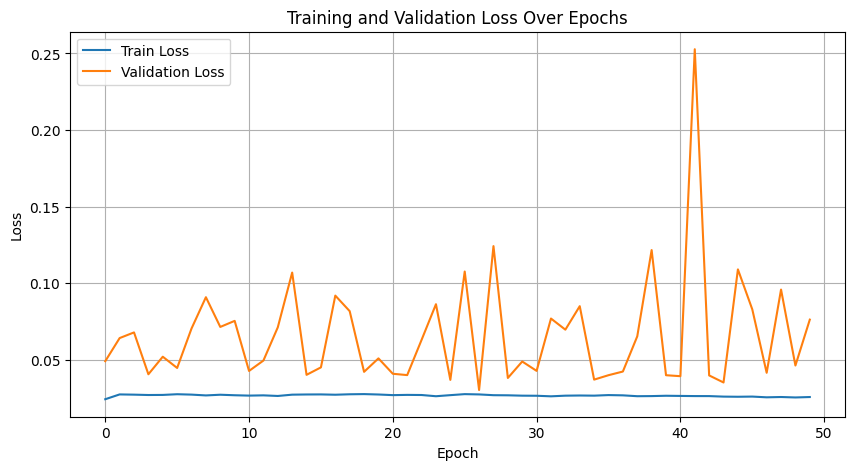

In [69]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_dnn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [70]:
model_path = "soc_dnn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [71]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [72]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.020984
Test MAE: 0.123687
Test StdDev: 0.135635


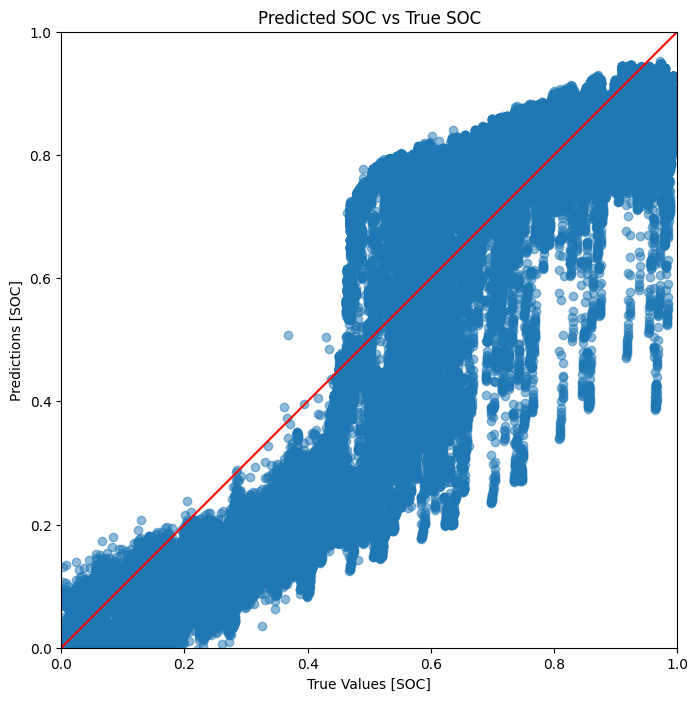

In [73]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

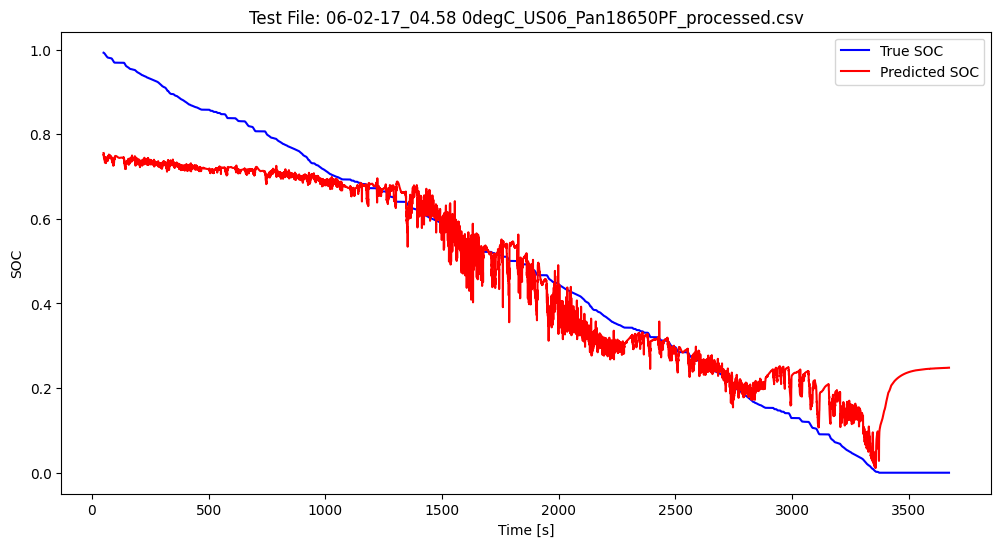

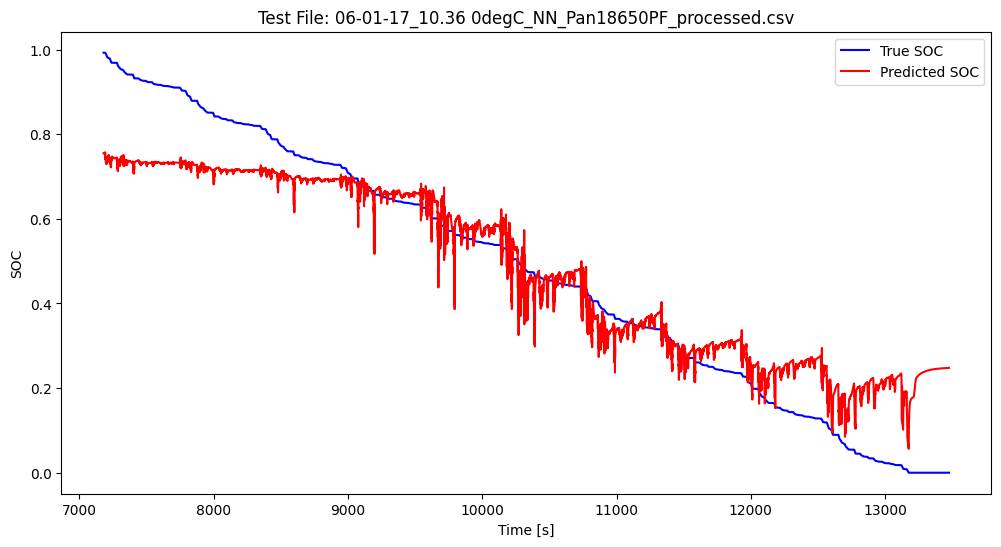

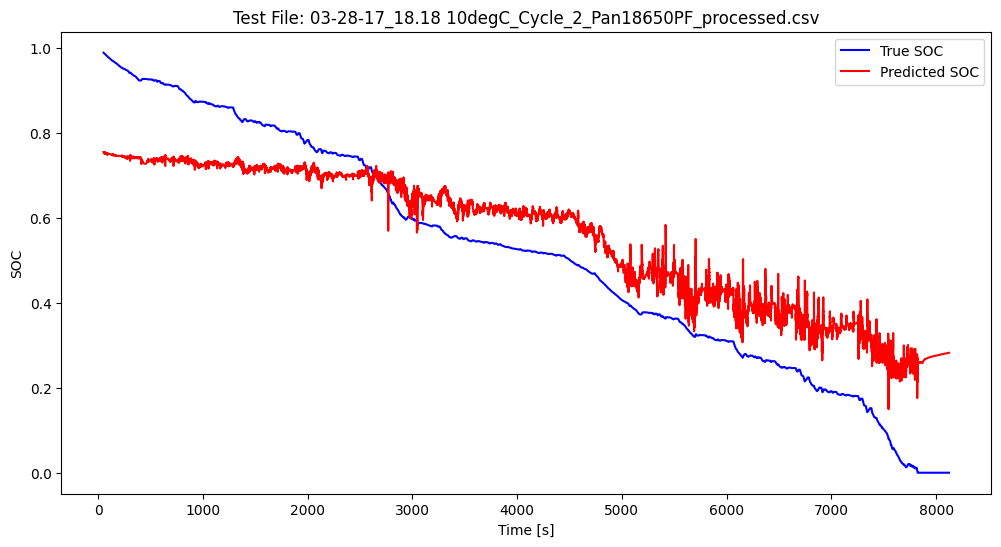

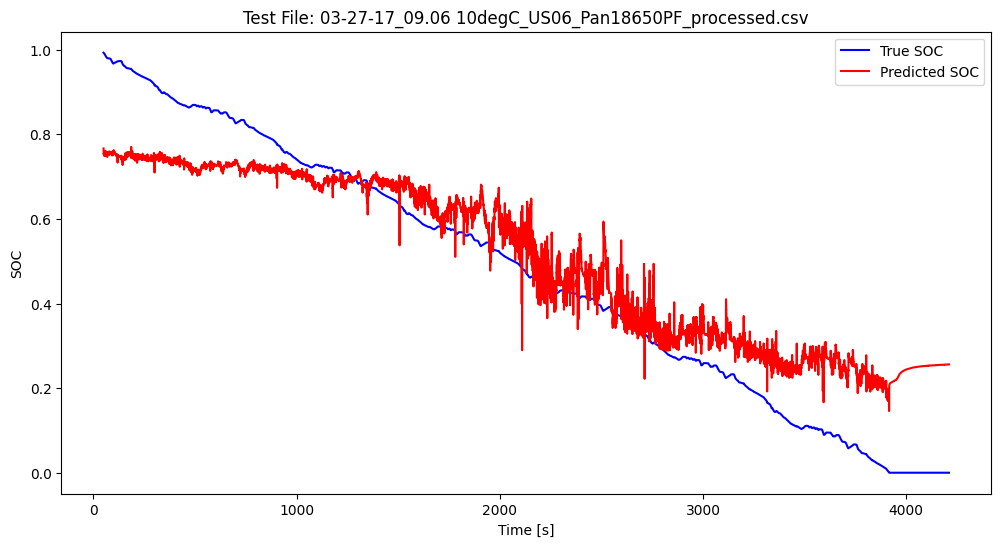

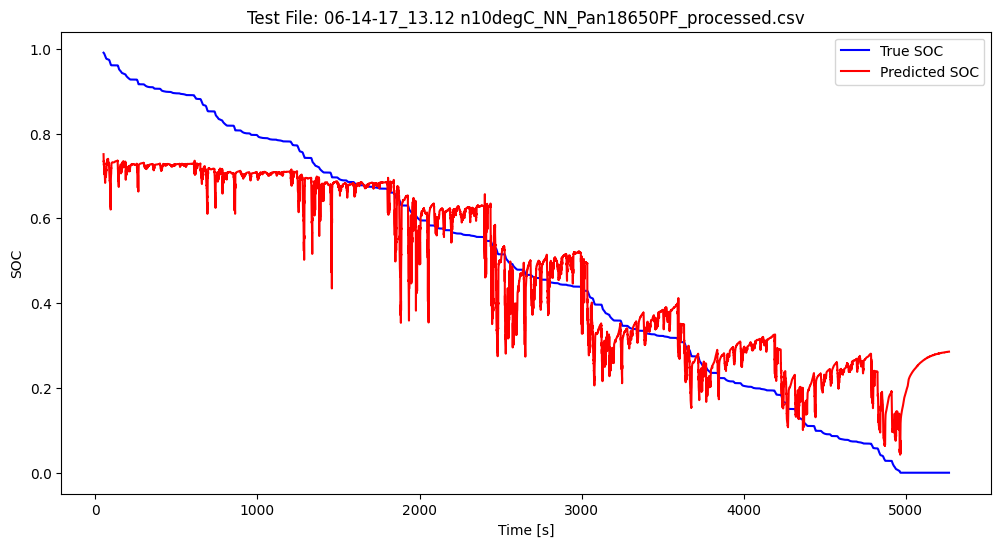

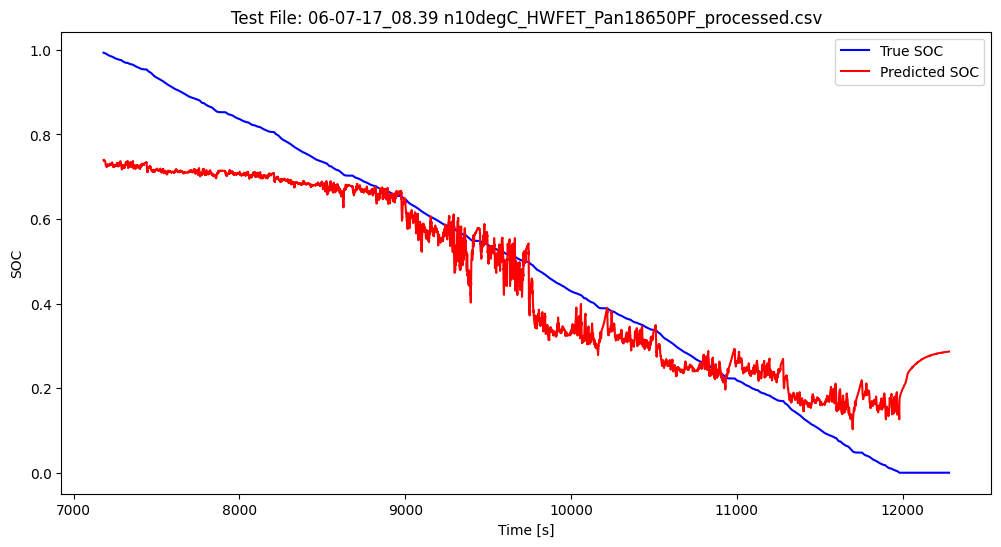

In [61]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)